In [110]:
import numpy as np
import os
import sys
from ape.sampling import SamplingJob
from ape.qchem import QChemLog
from ape.common import get_electronic_energy
from ape.InternalCoordinates import getXYZ
from tnuts.qchem import get_level_of_theory
from tnuts.job.job import Job
from rigidObject import RigidObject
from numba import njit, jit
from ads.sph_harm import Yij as Y, Ybasis
import rmgpy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import scipy.special
from copy import deepcopy
from ads.adsorbate import Adsorbate
from ads.hamiltonian import set_anharmonic_H, Hlmllmm
from sklearn.metrics import r2_score
from sympy.physics.wigner import gaunt

%matplotlib notebook
hbar1 = constants.hbar / constants.E_h # in hartree*s
hbar2 = constants.hbar * 10 ** 20 / constants.amu # in amu*angstrom^2/s

In [118]:
system = 'METH'
T = 298 # K

In [119]:
cwd = os.getcwd()
s = '{}-freq.out'
if system == 'ETH1':
    wd = os.path.join(cwd, 'ETH1-CHA')
    name = s.format('ETH1-CHA')
    nads = 8
elif system == 'ETH2':
    wd = os.path.join(cwd, 'ETH2-CHA')
    name = s.format('ETH2-CHA')
    nads = 8
elif system == 'METH':
    wd= os.path.join(cwd, 'METH-CHA')
    name = s.format('METH-CHA')
    nads = 5
elif system == 'PROP1':
    wd = os.path.join(cwd, 'PROP1-MFI')
    name = s.format('PROP1-MFI')
    nads = 11
elif system == 'PROP2':
    wd = os.path.join(cwd, 'PROP2-MFI')
    name = s.format('PROP2-MFI')
    nads = 11
elif system == 'PROP3':
    wd = os.path.join(cwd, 'PROP3-MFI')
    name = s.format('PROP3-MFI')
    nads = 11
filepath = os.path.join(wd, name)

In [120]:
v = np.load(os.path.join(wd, 'v.npy'))
xsph = np.load(os.path.join(wd, 'xsph.npy'))
# Save in text form for C++
np.savetxt(os.path.join(wd, 'vdat.txt'), np.vstack((xsph.T, v)).T)

In [121]:
try:
    lam = np.load(os.path.join(wd, 'lam.npy'))
    # Get ahat
    y = Y(xsph, lmax=lam)
    U,S,V = np.linalg.svd(y, full_matrices=False)
    ahat = np.matmul( np.linalg.pinv(np.matmul(U, np.matmul( np.diag(S), V))), np.array(v))
except FileNotFoundError:
    lam = 10
    converge = False
    while not converge:
        # GET BASES FOR MAX l = λ 
        y = Y(xsph, lmax=lam)

        # SOLVE THE COEFFICIENTS
        U,S,V = np.linalg.svd(y, full_matrices=False)
        ahat = np.matmul( np.linalg.pinv(np.matmul(U, np.matmul( np.diag(S), V))), np.array(v))
        predicted = np.zeros(len(v))
        for i,xpair in enumerate(xsph):
            ind = 0
            for l in range(lam):
                for m in np.linspace(-l, l, 2*l+1):
                    piece = Ybasis(l, int(m), *xpair)
                    #piece = ybas(l,int(m),THETA,PHI)
                    #piece = np.real(scipy.special.sph_harm(m,l,PHI,THETA))
                    predicted[i] += ahat[ind] * piece
                    ind += 1

        R2 = r2_score(v, predicted)
        if (1-R2 < 0.05):
            converge = True
            print(lam)
            np.save(os.path.join(wd, 'lam.npy'), lam)
        else:
            print('λ =', lam, R2, 1-R2)
            lam += 1
np.savetxt(os.path.join(wd, 'adat.txt'), ahat)

In [122]:
Log = QChemLog(os.path.join(wd,
            'ads{}.q.out'.format(nads)))
conformer = Log.load_conformer()[0]
print(np.sum(1/np.array(conformer.modes[1].inertia.value)))
print(conformer.modes[1].get_partition_function(T))
#print(conformer.modes[1].get_entropy(T))

0.9243375553552631
148.79351019020046


In [116]:
sqrtN = 20
I = conformer.modes[1].inertia.value
np.save(os.path.join(wd, 'I.npy'), I)
#np.savetxt(os.path.join(wd, 'I.txt'), I)
print(I)
I = 1/np.sum(1/np.array(conformer.modes[1].inertia.value))
print(I)

[17.23991666 60.06870512 67.72657787]
11.183458562674836


In [123]:
print(np.load(os.path.join(wd, 'I.npy')))
print(conformer.modes[1].symmetry)

[3.20707984 3.22669583 3.30455216]
3


In [38]:
#Humrr = set_anharmonic_H(ahat, I, sqrtN, 0, None)
# Solve eigenvalues for ROTATION only
Lam = 1
Lam_prev = 0
H_prev = None
Qold = np.log(sys.float_info[0])
result_info = []
converge = False
while not converge:
    Lam += 1
    H = set_anharmonic_H(ahat, I,
            Lam, Lam_prev,
            H_prev=H_prev)
    H_prev = deepcopy(H)
    eig, v = np.linalg.eigh(H)
    E = eig-eig[0]
    Q = np.sum(np.exp(-beta*E))

    if Qold == np.log(sys.float_info[0]):
        print("# \n# \t %d \t\t-\t\t-" % Lam) #first run
    else:
        print("# \n# \t %d \t\t %.10f \t\t %.10f" % (Lam,np.abs(Q-Qold),Q))

    if ((abs(Q-Qold)<1e-4)):
    #if ((abs(Q-Qold)<100)):
        print("# Convergence criterion met")
        print("# ------------------------------------")
        converge = True
    Qold = Q

# 
# 	 2 		-		-
# 
# 	 3 		 1.4066194296 		 2.4066298079
# 
# 	 4 		 1.1057801057 		 3.5124099135
# 
# 	 5 		 0.8019207227 		 4.3143306363
# 
# 	 6 		 0.3919145464 		 4.7062451826
# 
# 	 7 		 0.3801883433 		 5.0864335260
# 
# 	 8 		 0.0213722586 		 5.0650612674
# 
# 	 9 		 0.0256999241 		 5.0393613432
# 
# 	 10 		 0.0621976891 		 5.1015590324
# 
# 	 11 		 0.0176708632 		 5.1192298955
# 
# 	 12 		 0.3388663381 		 5.4580962336
# 
# 	 13 		 0.1176122796 		 5.5757085133
# 
# 	 14 		 0.0954704156 		 5.4802380976
# 
# 	 15 		 0.0782448404 		 5.5584829380
# 
# 	 16 		 0.1441558554 		 5.7026387934
# 
# 	 17 		 0.0111924078 		 5.6914463856
# 
# 	 18 		 0.1262858601 		 5.8177322457
# 
# 	 19 		 0.1663716946 		 5.6513605511
# 
# 	 20 		 0.0491778768 		 5.7005384279
# 
# 	 21 		 0.0996831834 		 5.8002216113
# 
# 	 22 		 0.0503875485 		 5.8506091597
# 
# 	 23 		 0.0362128388 		 5.8143963210
# 
# 	 24 		 0.0395989556 		 5.8539952766
# 
# 	 25 		 0.0010000587 		 5.8529952179
# 
# 	 26 		 0.0248213979

In [34]:
print(*result_info)

# 
# 	 2 		-		- # 
# 	 3 		-		- # 
# 	 4 		-		- # 
# 	 5 		-		- # 
# 	 6 		-		-


In [ ]:
Hfr = set_anharmonic_H(np.zeros(len(ahat)), I, sqrtN, 0, None)

In [46]:
((Humrr - Hfr) == (Humrr-Hfr)).all()

True

In [10]:
eig,eigvecs = np.linalg.eigh(Humrr)
Es = eig-eig[0]
beta = 1/constants.kB/300*constants.E_h
Q = np.sum(np.exp(-beta*(Es)))
print(np.mean(Es))
print(Q)

0.015264974539823875
5.558482937998093


In [55]:
print(Humrr-Hfr)

0.05023891056384133


<IPython.core.display.Javascript object>


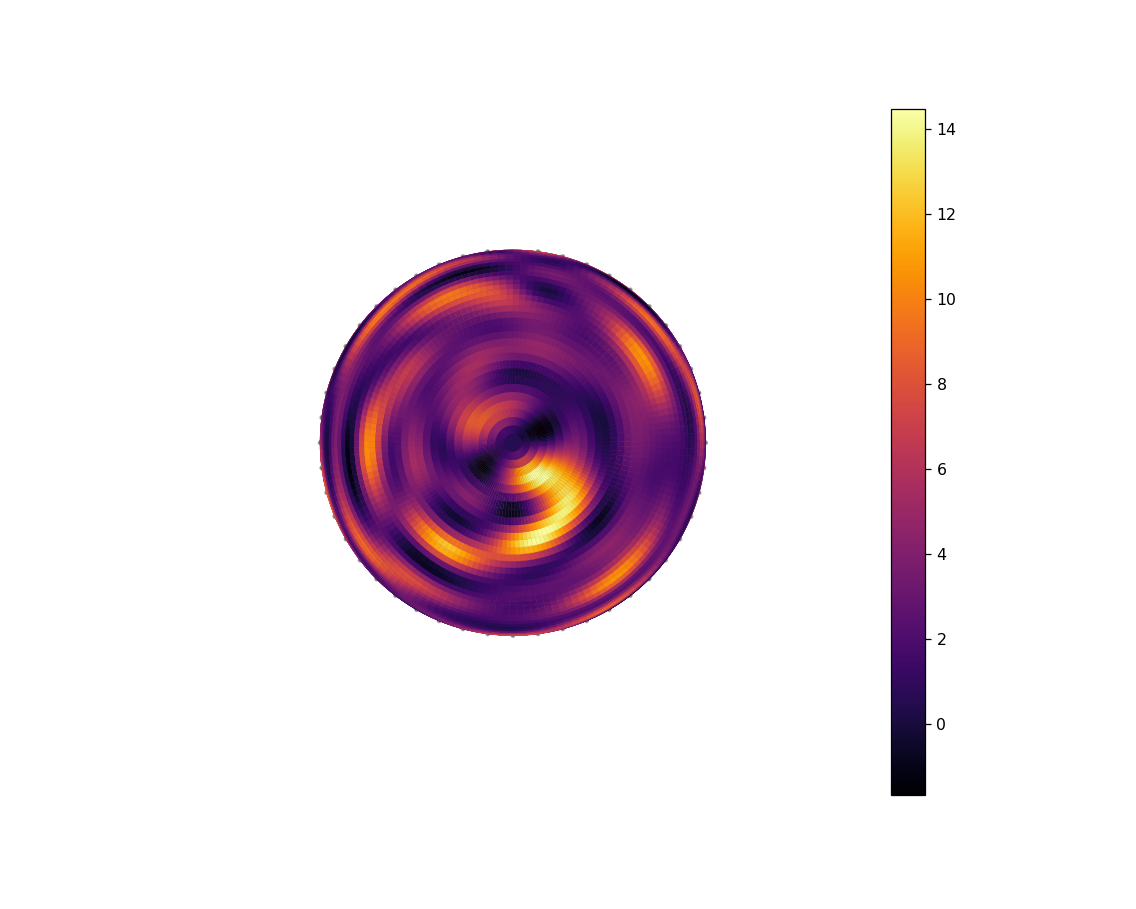

In [25]:
# PLOT POTENTIAL
from matplotlib import cm, colors
from ads.sph_harm import Yij as Y, Ybasis
%matplotlib notebook
lmax=np.load(os.path.join(wd, 'lam.npy'))
xsph = np.load(os.path.join(wd, 'xsph.npy'))
v = np.load(os.path.join(wd, 'v.npy'))

# GET BASES FOR MAX l = λ 
y = Y(xsph, lmax=lmax)
#Yb = Y(np.transpose(xsph), lmax=8)
#print(len(Yb))

# SOLVE THE COEFFICIENTS
U,S,V = np.linalg.svd(y, full_matrices=False)
ahat = np.matmul( np.linalg.pinv(np.matmul(U, np.matmul( np.diag(S), V))), np.array(v))
#print(ahat)

# PLOT THE APPROXIMATE FUNCTION
theta, phi = np.linspace(0, np.pi, 75), np.linspace(0, 2*np.pi, 150)
THETA, PHI = np.meshgrid(theta, phi)
R = np.zeros(shape=THETA.shape)
lam = int(np.sqrt(len(ahat)))
ind = 0
for l in range(lam):
    for m in np.linspace(-l, l, 2*l+1):
        piece = Ybasis(l, int(m), THETA, PHI)
        #piece = ybas(l,int(m),THETA,PHI)
        #piece = np.real(scipy.special.sph_harm(m,l,PHI,THETA))
        R += ahat[ind] * piece * 627.5
        ind += 1
R0 = 10000.0
X = (R+R0) * np.sin(THETA) * np.cos(PHI)
Y = (R+R0) * np.sin(THETA) * np.sin(PHI)
Z = (R+R0) * np.cos(THETA)
norm = colors.Normalize()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d', frame_on=False)
ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, #cmap=plt.get_cmap('cividis'),
    facecolors=cm.inferno(norm(R)),
    linewidth=.2, antialiased=True, alpha=1., shade=False)
#ax.plot_wireframe(
#    X, Y, Z, rstride=1, cstride=1,
#    color='b',
#    linewidth=0.2, antialiased=False, alpha=.5)

fig.colorbar(cm.ScalarMappable(norm=norm, cmap='inferno'), orientation='vertical')

#r = v*627.5+R0
#xsphma = np.ma.masked_less(np.transpose(xsph), 0.025)
#ax.scatter(xs=r*np.sin(xsphma[0])*np.cos(xsphma[1]),
#          ys = r*np.sin(xsphma[0])*np.sin(xsphma[1]),
#          zs = r*np.cos(xsphma[0]),
#          marker='.',
#          color='k',
#          alpha=0.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Hide grid
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.view_init(elev=90, azim=180.)

fig.savefig(os.path.join(wd,'V_l{}.png'.format(lmax)), transparent=True)